In [0]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

start = datetime.datetime(2012, 9, 1)
end = datetime.datetime(2019, 8, 31)

ticker = 'JNJ'

df = web.DataReader("JNJ", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,128.080002,126.629997,127.419998,127.800003,8889500.0,127.800003
2019-08-27,132.399994,129.100006,129.880005,129.639999,20183800.0,129.639999
2019-08-28,128.869995,127.010002,127.860001,128.679993,9878800.0,128.679993
2019-08-29,129.199997,126.830002,128.839996,128.240005,6749900.0,128.240005
2019-08-30,129.100006,127.620003,128.270004,128.360001,7371100.0,128.360001


In [3]:
df.shape

(1759, 6)

In [4]:
df = df[['Open','High','Low','Close','Volume']]
df['HL_PCT']= (df['High'] - df['Close']) / df['Close'] *100
df['PCT_change']= (df['High']-df['Open']) / df['Open'] *100
df=df[['Close','HL_PCT','PCT_change','Volume']]
df.head(3)

,Close,HL_PCT,PCT_change,Volume
Date,,,,
2012-09-04,67.260002,0.416293,0.074090,8402700.0
2012-09-05,67.269997,0.891937,0.637604,9266000.0
2012-09-06,67.839996,0.560149,0.753215,13075500.0


In [0]:
import math

forecast_col = 'Close'
#no na in data but good practice
df.fillna(-99999, inplace=True)

n=7 #days
#n=0.01*len(df) #shift is 1% of length of df
forecast_out = int(math.ceil(n)) #make n integer

df['label'] = df[forecast_col].shift(-forecast_out)

In [0]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X = np.array(df.drop(['label'],1))
X = preprocessing.scale(X)
X_lately= X[-forecast_out:] #shift the most recent data (e.g. 95-100)
X = X[:-forecast_out] #shift data until beginning of X_lately (e.g. 0-94)
#print(X, len(X))

df.dropna(inplace=True)
y = np.array(df['label'])
#print(len(X)==len(y))

#X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression(n_jobs=-1) #-1 = efficient/adaptive threading enabled
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [9]:
accuracy = clf.score(X_test, y_test)
print('accuracy is %f' %accuracy)

accuracy is 0.982140


In [10]:
accuracy = clf.score(X_test[-10:],y_test[-10:])
print('accuracy is %f' %accuracy)

accuracy is 0.968521


In [11]:
forecast_set= clf.predict(X_lately)
forecast_set

array([131.12028984, 127.35320264, 127.55779113, 128.85256503,
       128.34435419, 128.20039441, 128.25688133])

In [12]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [13]:
import numpy as np
import math
import pandas as pd

#from sklearn import preprocessing, cross_validation
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor as NNR
from sklearn.linear_model import LinearRegression as LRR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.gaussian_process import GaussianProcessRegressor as GPR

regs = [SVR(), NNR(), LRR(), RFR(), DTR(), GPR()]
accuracy = []
forecast = []
for reg in regs:
    reg.fit(X_train, y_train);
    accu = reg.score(X_test,y_test);
    accuracy.append(accu)
    #print reg
    print('{0}: accuracy = {1:.3f}'.format(str(reg)[:3], accu))
    forecast.append(reg.predict(X_lately))
    #print(forecast_set, accuracy, forecast_out)

SVR: accuracy = 0.940
MLP: accuracy = 0.615
Lin: accuracy = 0.982
Ran: accuracy = 0.977
Dec: accuracy = 0.960
Gau: accuracy = -3982.790


In [14]:
np.array(forecast).shape


(6, 7)

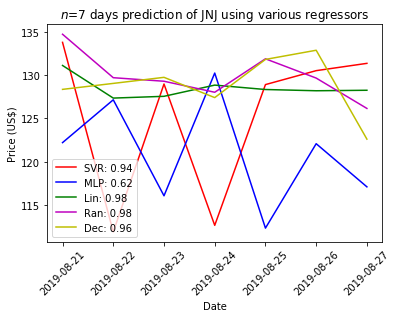

In [15]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import datetime as dt

last_date=df.index[-1]
#print last_date
next_date= last_date + dt.timedelta(days=1)
#print next_date

dates=[]
for i in range(n): #add 7 days
    next_date= last_date + dt.timedelta(days=i)
    dates.append(next_date)

colors=['r','b','g','m', 'y']
for j in range(len(forecast)-1): #not inluding result of GPR
    plt.plot(dates, forecast[j], '-', color=colors[j], label='{0}: {1:.2f}'.format(str(regs[j])[:3], accuracy[j]));
plt.xticks(rotation=45)
plt.legend(loc='best') #bottom right
plt.xlabel('Date')
plt.ylabel('Price (US$)')
plt.title('$n$=7 days prediction of {} using various regressors'.format(ticker))
plt.show()

In [0]:
df['Forecast'] = np.nan #create a new column for prediction and fill up with nan

import datetime as dt

last_date=df.index[-1]
#print last_date
next_date= last_date + dt.timedelta(days=1)
#print next_date

for i,j in zip(forecast_set,range(int(n))):
    next_date= last_date + dt.timedelta(days=j)
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i] #df.loc is the index location

In [17]:
df.tail(n+1)

,Close,HL_PCT,PCT_change,Volume,label,Forecast
Date,,,,,,
2019-08-20,130.600006,1.577333,0.530461,7302000.0,128.240005,NaN
2019-08-21,NaN,NaN,NaN,NaN,NaN,131.120290
2019-08-22,NaN,NaN,NaN,NaN,NaN,127.353203
2019-08-23,NaN,NaN,NaN,NaN,NaN,127.557791
2019-08-24,NaN,NaN,NaN,NaN,NaN,128.852565
2019-08-25,NaN,NaN,NaN,NaN,NaN,128.344354
2019-08-26,NaN,NaN,NaN,NaN,NaN,128.200394
2019-08-27,NaN,NaN,NaN,NaN,NaN,128.256881


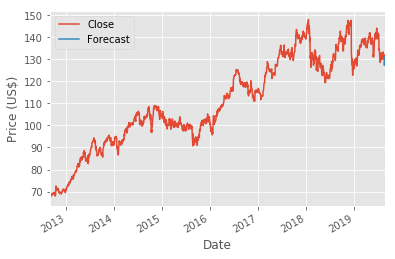

In [18]:
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
style.use('ggplot')

plt.figure(1)
df['Close'].plot()
df['Forecast'].plot()
plt.legend(loc='best') #bottom right
plt.xlabel('Date')
plt.ylabel('Price (US$)')
plt.show()

Text(0.5, 1.0, 'JNJ')

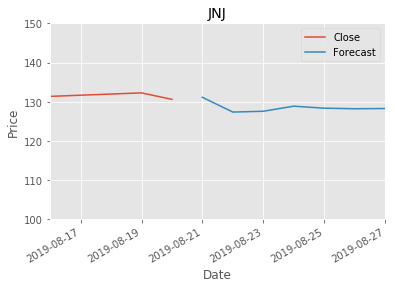

In [19]:
#Zoom in to prediction
df['Close'].plot()
df['Forecast'].plot()
ymax=max(df['Forecast'].values)
ymin=min(df['Forecast'].values)
plt.axis([df.index[-int(n+3)],df.index[-1], 100, 150]) #xmin,xmax,ymin,ymax
plt.legend(loc='best') #bottom right
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(ticker)
#df.Forecast.tail()

In [0]:
###save into pickle file
import pickle 
with open('linreg.pickle', 'wb') as f:
    pickle.dump(clf,f)
    
###load pickle file which requires no more training
pickle_in = open('linreg.pickle', 'rb')
clf=pickle.load(pickle_in)

In [0]:
import datetime

df['Forecast'] = np.nan #create a new column for prediction and fill up with nan

last_date=df.iloc[-1].name
last_unix=last_date.timestamp()
one_day= 86400 #seconds
next_unix= last_unix + one_day #next day
#print(df.tail())

###PARSE x-axis into date format
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i] #df.loc is the index location    
#print(df.tail())

import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
style.use('ggplot')



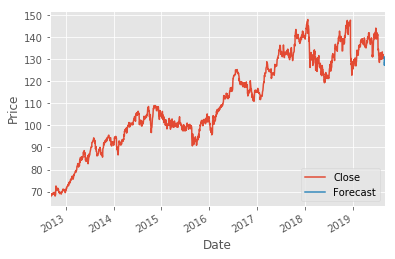

In [22]:
plt.figure(1)
df['Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4) #bottom right
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


Text(0, 0.5, 'Price')

<Figure size 432x288 with 0 Axes>

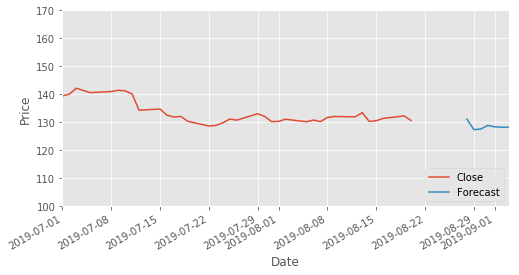

In [23]:
plt.figure(2)
#Zoom in to prediction
plt.figure(figsize=(8,4))
df['Close'].plot()
df['Forecast'].plot()
plt.axis([df.index[-50],df.index[-1],100,170]) #xmin,xmax,ymin,ymax
plt.legend(loc=4) #bottom right
plt.xlabel('Date')
plt.ylabel('Price')
#df.Forecast.tail()
